In [87]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
# euclidean distance
def euclidean(p1,p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))

In [89]:
# Method labels points based on closest centroid
def cluster_label(centroids:pd.DataFrame, point:pd.Series, df:pd.DataFrame):
    # current minimum distance
    min_dist = float('inf')
    # iterate through centroids
    for x in centroids.values:
        # distance between current point and centroid
        ndist = euclidean(x[:4],point[:4])
        if (ndist < min_dist):
            min_dist = ndist
            # label current point based on curent closest centroid
            df.loc[[point.name],['Labels']] = x[4:]

In [90]:
# Method to recalculate new centroids
def recalc_centroids(centroids:pd.DataFrame, df:pd.DataFrame, k:int):
    # group clusters based on label
    cluster_grp = df.groupby(['Labels'])
    
    # get average of each column (ignoring label column) 
    # to find values of new centroid
    for i in range(k):
        temp = cluster_grp.get_group('cluster_'+str(i+1)).iloc[:,:4].mean(axis = 0)
        temp.loc['Labels'] = 'cluster_'+str(i+1)
        centroids.iloc[i] = temp

In [91]:
# dataframe from csv file
df_test = pd.read_csv("K_means_test.csv", index_col = 'Id')
df_train = pd.read_csv("K_means_train.csv", index_col = 'Id')
df_valid = pd.read_csv("K_means_valid.csv", index_col = 'Id')

In [92]:
# Initialize k points as centroids
k = 3

# select k random inital centroids
centroids = df_train.sample(n=k)
print(centroids)

# optimal centroids provided by TA
#centroids = df_train.loc[[65,97,94]]

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm   Labels
Id                                                                    
151            6.3           3.7            5.0           2.1  unlabel
148            6.3           2.5            5.0           1.9  unlabel
76             5.5           2.4            3.8           1.1  unlabel


In [93]:
for i in range(k):
    centroids.iloc[[i],4] = ('cluster_' + str(i+1))

In [94]:
unsatisfied = True
while (unsatisfied):
    # cluster points based on closest centroid
    df_train.apply(lambda x: cluster_label(centroids,x,df_train), axis = 1)
    # deep copy of centroid
    prev = centroids.copy(deep = True)
    recalc_centroids(centroids,df_train,k)
    # check if convergence criterion is satisfied
    if (centroids.equals(prev)):
        unsatisfied = False

In [95]:
df_valid_copy = df_valid.copy()
for i in range(1,len(df_valid_copy.index)+1):
    df_valid_copy.loc[i,'Labels'] = df_train.loc[(df_train['SepalLengthCm'] == df_valid_copy.loc[i,'SepalLengthCm']) 
                 & (df_train['SepalWidthCm'] == df_valid_copy.loc[i,'SepalWidthCm'])
                 & (df_train['PetalLengthCm'] == df_valid_copy.loc[i,'PetalLengthCm']) 
                 & (df_train['PetalWidthCm'] == df_valid_copy.loc[i,'PetalWidthCm'])].Labels.item()

isValid = 'valid'
for i in range(1,len(df_valid_copy.index)+1):
    if(df_valid_copy.loc[i, 'Labels'] != df_valid.loc[i, 'Labels']):
        isValid = 'invalid'
    print("validation test: " + df_valid_copy.loc[i, 'Labels'] + " matches " + "original: " + df_valid.loc[i, 'Labels'] + " = " + isValid)

validation test: cluster_3 matches original: cluster_1 = invalid
validation test: cluster_3 matches original: cluster_1 = invalid
validation test: cluster_2 matches original: cluster_2 = invalid
validation test: cluster_2 matches original: cluster_2 = invalid
validation test: cluster_1 matches original: cluster_3 = invalid
validation test: cluster_1 matches original: cluster_3 = invalid


In [59]:
# rename df_test label column to match df_train
df_test.rename(columns = {'labels': 'Labels'}, inplace = True)

# get test labels from training data
for i in range(1,len(df_test.index)+1):
    df_test.loc[i,'Labels'] = df_train.loc[(df_train['SepalLengthCm'] == df_test.loc[i,'SepalLengthCm']) 
                 & (df_train['SepalWidthCm'] == df_test.loc[i,'SepalWidthCm'])
                 & (df_train['PetalLengthCm'] == df_test.loc[i,'PetalLengthCm']) 
                 & (df_train['PetalWidthCm'] == df_test.loc[i,'PetalWidthCm'])].Labels.item()

In [60]:
df_test.to_csv('K_means_test_predict2.csv')

In [61]:
data = df_train.drop(['Labels'],axis=1).values
clusters = df_train['Labels'].values

In [62]:
# use tsne on df_train, with target dimensions = 2
# arbitrarily use seed = 1
tsne = TSNE(n_components=2,random_state = 1)

In [63]:
out = tsne.fit_transform(data)

C:\Users\minki\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\minki\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [64]:
df = pd.DataFrame()
df['x'] = out[:,0]
df['y'] = out[:,1]
print(df)

             x          y
0    11.699841 -23.251373
1    12.459087 -20.697445
2    11.250875 -20.431904
3    11.520447 -20.156269
4    11.212588 -23.376535
..         ...        ...
146  -3.951399  12.626282
147  -7.457144  10.085898
148  -9.024148   8.266057
149 -10.653926   8.179654
150 -10.421091   9.081377

[151 rows x 2 columns]


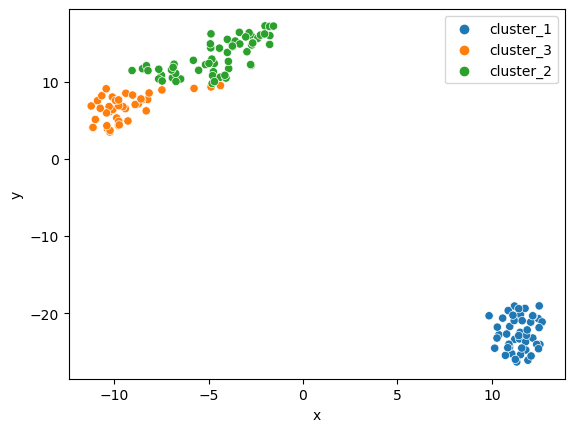

In [65]:
sns.scatterplot(x='x', y='y', data = df, hue = clusters)
plt.show()